# Visual Reasoning Baseline Model

1. Data preprocessing 어떻게 하면될까?
 - Image feature를 resnet으로 미리 추출해둘까? --> baseline돌리기 까다로움
 - DataLoader 구성을 어떻게하면 좋을까? --> DataSet class 안에서 feature를 return 할까? 아니면 ResNet을 밖에둘까


2. Baseline Model 설계를 어떻게?
 - Encoder: image encoding 어떻게 하면 될까? Answer Image 3개를 한꺼번에 encoding? 혹은 각각 encoding 한 후 Weight Sum??
 - Decoder: Answer 후보 중 정답후보를 어떻게 고를까? Similarity 기준? KL 같은 분포기준? Attention 기반 Scoring??


3. SOTA Model 설계를 어떻게? 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. Import all packages

In [2]:
import pandas as pd
import numpy as np
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from PIL import Image, ImageDraw
import cv2

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_location = './NanumGothic.ttf'
#font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.


In [3]:
'''
nrows,ncols=6,15
fig,ax = plt.subplots(nrows,ncols,figsize=(15,6))
plt.subplots_adjust(wspace=0, hspace=0) 
for i,j in enumerate(malignant[:nrows*ncols]):
    fname = os.path.join(imgpath ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='red')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')
    
import plotly.express as px

# Create grid of sample images 
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')
image indices: [1438  355 2681 1007 2970 2925  605 1739  270 1641 1080  786 1840   62
 2633  734 1712  511 2681 2973  180 2601  500 1959  869    3 2359 3153
  345 1307]
torch.Size([3, 146, 482])

'''

'\nnrows,ncols=6,15\nfig,ax = plt.subplots(nrows,ncols,figsize=(15,6))\nplt.subplots_adjust(wspace=0, hspace=0) \nfor i,j in enumerate(malignant[:nrows*ncols]):\n    fname = os.path.join(imgpath ,j +\'.tif\')\n    img = Image.open(fname)\n    idcol = ImageDraw.Draw(img)\n    idcol.rectangle(((0,0),(95,95)),outline=\'red\')\n    plt.subplot(nrows, ncols, i+1) \n    plt.imshow(np.array(img))\n    plt.axis(\'off\')\n    \nimport plotly.express as px\n\n# Create grid of sample images \ngrid_size=30\nrnd_inds=np.random.randint(0,len(train_ts),grid_size)\nprint("image indices:",rnd_inds)\n\nx_grid_train=[train_ts[i][0] for i in rnd_inds]\ny_grid_train=[train_ts[i][1] for i in rnd_inds]\n\nx_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)\nprint(x_grid_train.shape)\n    \nplot_img(x_grid_train,y_grid_train,\'Training Subset Examples\')\nimage indices: [1438  355 2681 1007 2970 2925  605 1739  270 1641 1080  786 1840   62\n 2633  734 1712  511 2681 2973  180 2601  500 1959  869   

## 2. Preparation of datasets

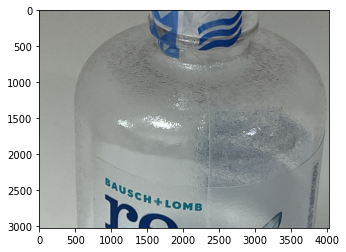

In [4]:
class Config:
    def __init__(self, args=None):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.distributed = False
        self.gpu_id = "0"
        self.HOME_DIR = "./datasets/"
        self.TASK_NAME = "task3/"
        self.FOLDER_NAME = os.listdir(f"{self.HOME_DIR}{self.TASK_NAME}/")[0]+'/'
        file_list = os.listdir(f"{self.HOME_DIR}{self.TASK_NAME}{self.FOLDER_NAME}")
        for file_name in file_list:
            if file_name.endswith('.json'):
                json_file = file_name
                file_list.remove(file_name)
        self.IMAGE_LIST = file_list
        self.JSON_NAME = json_file
        self.input_dim = 512
        self.mlp_hidden = 1024


config = Config()
a_image_file = config.HOME_DIR+config.TASK_NAME+config.FOLDER_NAME+config.IMAGE_LIST[0]
a_image = plt.imread(a_image_file)
plt.imshow(a_image)

In [5]:
def get_data(config):
    
    home_dir = config.HOME_DIR
    task_name = config.TASK_NAME
    dir_list = os.listdir(home_dir+task_name)
    sample_list = []
    
    for directory in dir_list:
        FOLDER_NAME = directory+"/"
        JSON_NAME = directory+".json"
        FILE_PATH = home_dir+task_name+FOLDER_NAME
        a_data = json.load(open(FILE_PATH+JSON_NAME))
        a_data["file_path"] = FILE_PATH
        a_data["answer1"] = [a_data["Answers"][0]]
        a_data["answer2"] = [a_data["Answers"][1]]
        a_data["answer3"] = [a_data["Answers"][2]]
        del a_data["Answers"]
        sample_list.append(a_data)
        
    return sample_list

def get_img_argumentation():
    #이미지 전처리를 위한 이미지 크기 변환 및 각도조정을 위한 transform 선언

    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    
    return transform


In [6]:
class Similarity1_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, config=None, transform=None):
        self.df = df
        self.config = config
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        
        target = sample["correct_answer_group_ID"][0]
        category = sample["category"]
        q_img = sample["file_path"] + sample["Questions"][0]["images"][0]["image_url"]
        a1_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer1"][0]["images"]]
        a2_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer2"][0]["images"]]
        a3_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer3"][0]["images"]]
        
        q_img_feature = Image.open(q_img).convert('RGB')  #이미지 데이터를 RGB형태로 읽음 
        q_img_feature = self.transform(q_img_feature)  #이미지 데이터의 크기 및 각도등을 변경
        
        a1_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a1_img]
        a2_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a2_img]
        a3_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a3_img]

        
        return {
            "target": target,
            "q_img": q_img_feature,
            "a1_imgs": a1_img_feature,
            "a2_imgs": a2_img_feature,
            "a3_imgs" : a3_img_feature 
        }
        
    

In [7]:
def make_sequential(in_channels, out_channels, *args, **kwargs):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, *args, **kwargs),
           nn.BatchNorm2d(out_channels),
           nn.ReLu(),
           nn.MaxPool2d(*args, **kwargs))

class VRSimilarity(nn.Module):
    def __init__(self, config):
        super(VRSimilarity, self).__init__()
        
        self.config = config
        self.backborne = torchvision.models.resnet50(pretrained=True)
        self.backborne.fc = nn.Linear(self.backborne.fc.in_features, self.config.input_dim)
        self.fc = nn.Sequential(
                    nn.Linear(self.config.input_dim*2, self.config.mlp_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(self.config.mlp_hidden, 2),
        )

    def forward(self, samples):
        
        #Question Image Feature
        q = self.backborne(samples["q_img"])
        
        #Answer Image Feature
        a1_img1 = self.backborne(samples["a1_imgs"][0])
        a2_img1 = self.backborne(samples["a2_imgs"][0])
        a3_img1 = self.backborne(samples["a3_imgs"][0])

        
        q_a1 = torch.cat([q, a1_img1], axis=1)
        q_a2 = torch.cat([q, a2_img1], axis=1)
        q_a3 = torch.cat([q, a3_img1], axis=1)

        
        q_a1_logit = self.fc(q_a1)
        q_a2_logit = self.fc(q_a2)
        q_a3_logit = self.fc(q_a3)

        
        return {
            "q_a1_logit": F.log_softmax(q_a1_logit, dim=1),
            "q_a2_logit": F.log_softmax(q_a2_logit, dim=1),
            "q_a3_logit": F.log_softmax(q_a3_logit, dim=1)

        }


In [8]:
def train_fn(model, train_loader, optimizer, loss_fn, config):
    
    total_count_correct = 0
    total_num_example = 0
    total_loss = []
    
    model.train()
    device = config.device
    
    for batch in tqdm(train_loader):          
        
        #Question Image Feature
        batch["q_img"] = batch["q_img"].to(device)
        
        #Answer Image Feature
        batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
        batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
        batch["a3_imgs"][0] = batch["a3_imgs"][0].to(device)

        logits = model(batch)

        target_a1, target_a2, target_a3 = (batch["target"] == 1).type(torch.long).to(device), (batch["target"] == 2).type(torch.long).to(device),(batch["target"] == 3).type(torch.long).to(device)

        loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
        loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
        loss_a3 = loss_fn(logits["q_a3_logit"].squeeze(), target_a3)
        
        loss = loss_a1 + loss_a2 + loss_a3
        total_loss.append(loss.item())
        
        predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
        total_num_example = total_num_example + target_a1.size(0)
        
        predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
        total_num_example = total_num_example + target_a2.size(0)

        predicted_a3 = logits["q_a3_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a3 == target_a3).item()
        total_num_example = total_num_example + target_a3.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         print("total_count_correct", total_count_correct)
#         print("total_num_example", total_num_example)
    print("TRAIN_LOSS:", str(sum(total_loss)/total_num_example) + " TRAIN_Accuracy: " + str(total_count_correct/total_num_example) )
   # print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )


In [9]:
def valid_fn(model, valid_loader, config):
    
    total_count_correct = 0
    total_num_example = 0
    device = config.device
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):          
            #Question Image Feature
            batch["q_img"] = batch["q_img"].to(device)

            #Answer Image Feature
            batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
            batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
            batch["a3_imgs"][0] = batch["a3_imgs"][0].to(device)
            
            logits = model(batch)

            target_a1, target_a2, target_a3 = (batch["target"] == 1).type(torch.long).to(device), (batch["target"] == 2).type(torch.long).to(device),(batch["target"] == 3).type(torch.long).to(device)

            predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
            total_num_example = total_num_example + target_a1.size(0)

            predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
            total_num_example = total_num_example + target_a2.size(0)

            predicted_a3 = logits["q_a3_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a3 == target_a3).item()
            total_num_example = total_num_example + target_a3.size(0)

            '''
            print(predicted_a1)
            print(target_a1)
            print(predicted_a1 == target_a1)
            print(predicted_a2)
            print(target_a2)
            print(predicted_a2 == target_a2)
            print("total_count_correct", total_count_correct)
            print("total_num_example", total_num_example)
            '''

    print("Valid Accuracy: " + str(total_count_correct/total_num_example) )


In [10]:
config = Config()

df = get_data(config)
df = pd.DataFrame(df)
train_df, valid_df = train_test_split(df)
transform = get_img_argumentation()

train_datasets = Similarity1_Dataset(train_df, transform=transform)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=64)

valid_datasets = Similarity1_Dataset(valid_df, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=64)

vrs1_model = VRSimilarity(config)
#vrs1_model = torch.nn.DataParallel(vrs1_model)
vrs1_model = vrs1_model.to(config.device)
if config.distributed:
    #vrs1_model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[config.gpu])    
    vrs1_model = torch.nn.parallel.DistributedDataParallel(model)    

optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.0001)
loss_fn = nn.NLLLoss(reduction="sum")

In [11]:
for idx in range(3):
    train_fn(vrs1_model, train_loader, optimizer, loss_fn, config)
    valid_fn(vrs1_model, valid_loader, config)

100%|██████████| 19/19 [12:33<00:00, 39.68s/it]


TRAIN_LOSS: 0.6354241163596801 TRAIN_Accuracy: 0.654639175257732


100%|██████████| 7/7 [04:17<00:00, 36.80s/it]


Valid Accuracy: 0.6572407883461868


100%|██████████| 19/19 [12:34<00:00, 39.72s/it]


TRAIN_LOSS: 0.5487630140603886 TRAIN_Accuracy: 0.7001718213058419


100%|██████████| 7/7 [04:18<00:00, 36.99s/it]


Valid Accuracy: 0.6563838903170522


100%|██████████| 19/19 [12:45<00:00, 40.29s/it]


TRAIN_LOSS: 0.372490587649613 TRAIN_Accuracy: 0.8298969072164949


100%|██████████| 7/7 [04:23<00:00, 37.67s/it]

Valid Accuracy: 0.6083976006855184
